In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
def scale_features(df: pd.DataFrame, feature_names: list) -> pd.DataFrame:
    """Scale specified integer features using MinMaxScaler."""
    scaler = MinMaxScaler()
    df[feature_names] = scaler.fit_transform(df[feature_names])
    return df

def classify_features(df: pd.DataFrame) -> pd.DataFrame:
    """Classify features into Binary, Integer, Continuous, or Unknown."""
    summary = []
    for col in df.columns:
        col_data = df[col].dropna()
        unique_vals = set(col_data.unique())
        is_binary = unique_vals.issubset({0, 1})
        is_integer = np.all(np.equal(np.mod(col_data, 1), 0))
        
        if is_binary:
            feature_type = "Binary"
            details = f"Values: {sorted(unique_vals)}"
        elif is_integer:
            feature_type = "Integer"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        elif not is_integer and col_data.dtype.kind in 'fi':  # float or integer
            feature_type = "Continuous"
            details = f"Range: {col_data.min()} to {col_data.max()}"
        else:
            feature_type = "Unknown"
            details = f"Values: {sorted(unique_vals)}"
        
        summary.append({
            'Feature': col,
            'Type': feature_type,
            'Details': details
        })

    return pd.DataFrame(summary)

data = pd.read_csv('../data/all_data.csv')

# Classify feature types
feature_summary = classify_features(data)
print(feature_summary)

# Find integer features to scale
integer_features = feature_summary[feature_summary['Type'] == 'Integer']['Feature'].tolist()
integer_features = [feat for feat in integer_features if feat != 'persoon_leeftijd_bij_onderzoek']

# Scale integer features
data = scale_features(data, integer_features)

   adres_aantal_brp_adres  adres_aantal_verschillende_wijken  \
0                       1                                  1   
1                       4                                  2   
2                       6                                  4   
3                       3                                  2   
4                       3                                  2   

   adres_aantal_verzendadres  adres_aantal_woonadres_handmatig  \
0                          0                                 0   
1                          1                                 1   
2                          2                                 1   
3                          0                                 1   
4                          0                                 0   

   adres_dagen_op_adres  adres_recentst_onderdeel_rdam  \
0                 23240                              1   
1                  1971                              1   
2                  7247                     

In [3]:

# Prepare features and target
y = data[['Ja', 'checked']]
X = data.drop(['Ja', 'Nee', 'checked'], axis=1).astype(np.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [4]:
# Define and train the logistic regression model
# Define the regularization strength (alpha)
# This can be tuned using cross-validation
ridge_alpha = 1.0  # Example value; you may want to optimize this

# Create a Ridge regressor with the specified alpha
regressor = Ridge(
    alpha=ridge_alpha,
    fit_intercept=True,
    copy_X=True,
    random_state=42
)

pipeline = Pipeline([('regression', regressor)])

pipeline.fit(
    X_train, y_train['Ja']
)

threshold = (0.697021996059818 + 0.697013377682873) / 2.0  #approx. boundary value in dataset

# Predict and evaluate
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test['checked'], y_pred > threshold)
print(f"Model accuracy: {accuracy:.2%}")

Model accuracy: 89.66%


                                               Feature  Coefficient  \
290           relatie_overig_actueel_vorm__kostendeler     0.205419   
140                        contacten_onderwerp_no_show     0.115478   
142            contacten_onderwerp_overleg_met_inkomen     0.081073   
53              belemmering_dagen_financiele_problemen     0.069126   
155  contacten_soort_afgelopenjaar_document__uitgaand_     0.060299   
284                        relatie_kind_huidige_aantal     0.059843   
206  ontheffing_dagen_hist_vanwege_uw_medische_omst...    -0.054671   
200    instrument_reden_beeindiging_historie_succesvol    -0.042465   
2                            adres_aantal_verzendadres    -0.041327   
181                instrument_ladder_huidig_activering    -0.040549   
131    contacten_onderwerp_documenttype__overeenkomst_    -0.038783   
211  ontheffing_reden_hist_tijdelijke_ontheffing_ar...    -0.035410   
90              competentie_vakdeskundigheid_toepassen     0.034330   
179   

/var/folders/yv/gpc5sh7j5k3cls_fv_dpzntc0000gn/T/ipykernel_46352/24971204.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


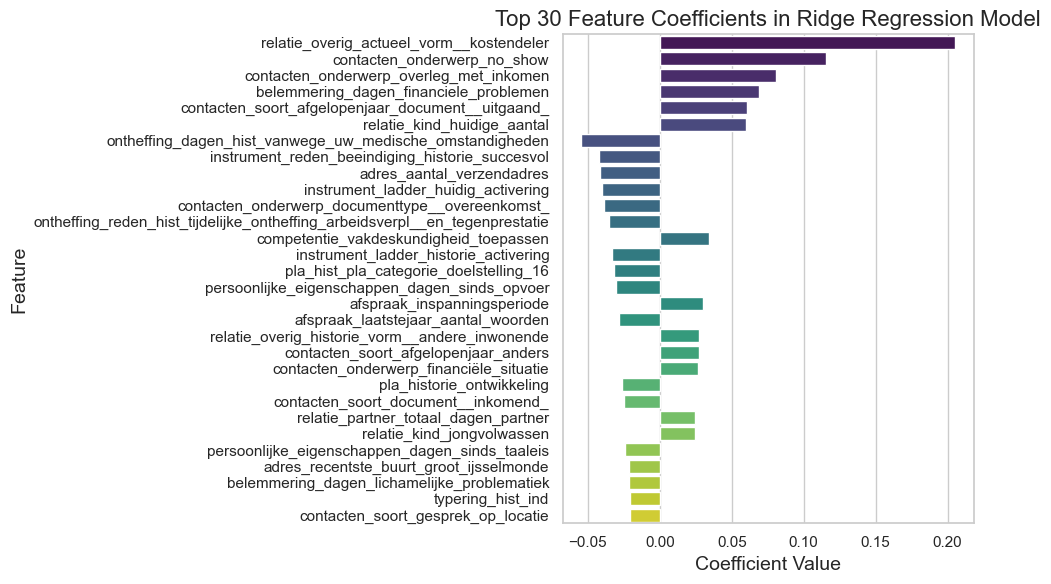

In [5]:
import seaborn as sns

linear_model = pipeline.named_steps['regression']

# Get the coefficients from the model
coefficients = linear_model.coef_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame mapping feature names to their coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate absolute coefficients for sorting
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort the DataFrame by absolute coefficient values in descending order
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Select the top 30 features
top_30_coef = coef_df_sorted.head(30)

print(top_30_coef)

# Optional: Sort the top 30 for better visualization (e.g., ascending order)
#top_30_coef = top_30_coef.sort_values(by='Coefficient')

# print coefficient for 'persoonlijke_eigenschappen_taaleis_voldaan' from coef_df
print(coef_df[coef_df['Feature'] == 'persoonlijke_eigenschappen_taaleis_voldaan'])
print(coef_df[coef_df['Feature'] == 'persoon_leeftijd_bij_onderzoek'])

# Set the plot style for better aesthetics
sns.set_theme(style='whitegrid')

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a horizontal bar plot
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=top_30_coef,
    palette='viridis'
)

# Add title and labels
plt.title('Top 30 Feature Coefficients in Ridge Regression Model', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

### Store to ONNX

In [6]:
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from skl2onnx import convert_sklearn
from onnx import helper
import onnxruntime as rt
import onnx

In [7]:
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

In [8]:
# Add note to onnx graph such that it saves both the predicted risk value
# and the 'checked' value based on if the risk value is higher than the
# provided threshold.

graph = onnx_model.graph
threshold_node = helper.make_node(
    "Constant",
    inputs=[],
    outputs=["threshold"],
    value=helper.make_tensor("value", onnx.TensorProto.FLOAT, [], [threshold])
)
graph.node.append(threshold_node)

greater_node = helper.make_node(
    "Greater",
    inputs=[graph.output[0].name, "threshold"],
    outputs=["boolean_output"]
)
graph.node.append(greater_node)

boolean_output = helper.make_tensor_value_info("boolean_output", onnx.TensorProto.BOOL, [None])
graph.output.extend([boolean_output])

In [9]:
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

# y_pred_onnx[0] = risk values
# y_pred_onnx[1] = boolean value indicating if high risk or not
accuracy_onnx_model = accuracy_score(y_test['checked'], y_pred_onnx[1])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.8966153846153846


2024-12-12 14:24:34.431200 [W:onnxruntime:, graph.cc:109 MergeShapeInfo] Error merging shape info for output. 'boolean_output' source:{-1,1} target:{-1}. Falling back to lenient merge.


In [ ]:
onnx.save(onnx_model, "../model/ridge_regression_model_baseline_all_data.onnx")